In [1]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot')
figsize(11,9)

import scipy.stats as stats

import pymc as pm

In [65]:
df = pd.read_csv('data/all_years_mass_shootings.csv', parse_dates=['Incident Date'])
df.head()

,Incident Date,State,City Or County,Address,# Killed,# Injured,Operations
0,2016-06-22,Washington,Lacey,500 block of Dutterow Road,3,1,NaN
1,2016-06-22,Georgia,Dekalb (county),Lancashire Drive and Central Drive,1,4,NaN
2,2016-06-22,Illinois,Chicago,3100 block of West Warren,0,4,NaN
3,2016-06-21,Kentucky,Louisville,2802 Rodman Street,2,2,NaN
4,2016-06-21,New Jersey,Willingboro,Mosshill Lane,0,4,NaN


In [66]:
df.Operations.describe()

/usr/local/codez/spikes/p35/lib/python3.5/site-packages/numpy/lib/function_base.py:3823: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Operations, dtype: float64

Was wondering what the Operations column meant.  Apparently nothing.  Deciding to drop that.

In [67]:
df = df.drop('Operations', 1)
df.head()

,Incident Date,State,City Or County,Address,# Killed,# Injured
0,2016-06-22,Washington,Lacey,500 block of Dutterow Road,3,1
1,2016-06-22,Georgia,Dekalb (county),Lancashire Drive and Central Drive,1,4
2,2016-06-22,Illinois,Chicago,3100 block of West Warren,0,4
3,2016-06-21,Kentucky,Louisville,2802 Rodman Street,2,2
4,2016-06-21,New Jersey,Willingboro,Mosshill Lane,0,4


In [11]:
df.State.describe()

count            500
unique            43
top       California
freq              48
Name: State, dtype: object

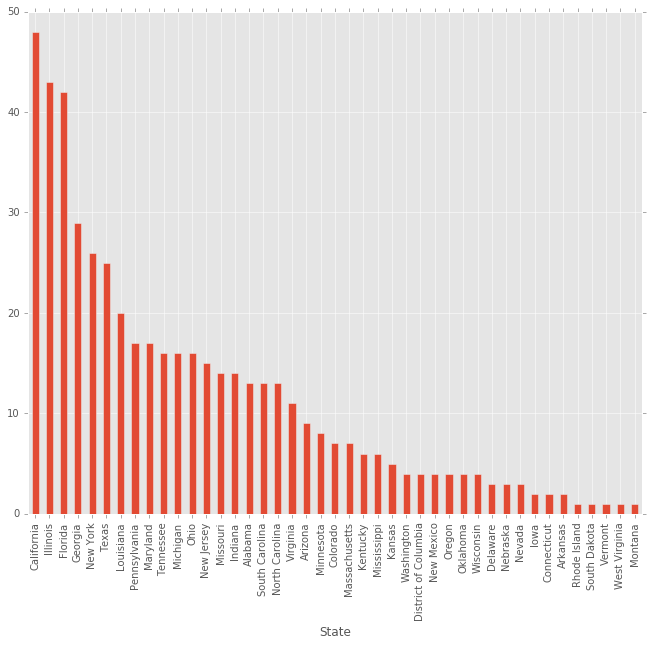

In [24]:
state_groups = df.groupby('State')
state_counts = state_groups.State.count()
state_counts = state_counts.sort_values(ascending=False)
state_counts.plot(kind='bar')

In [68]:
state_counts.describe()

count    43.000000
mean     11.627907
std      11.666034
min       1.000000
25%       3.500000
50%       7.000000
75%      16.000000
max      48.000000
Name: State, dtype: float64

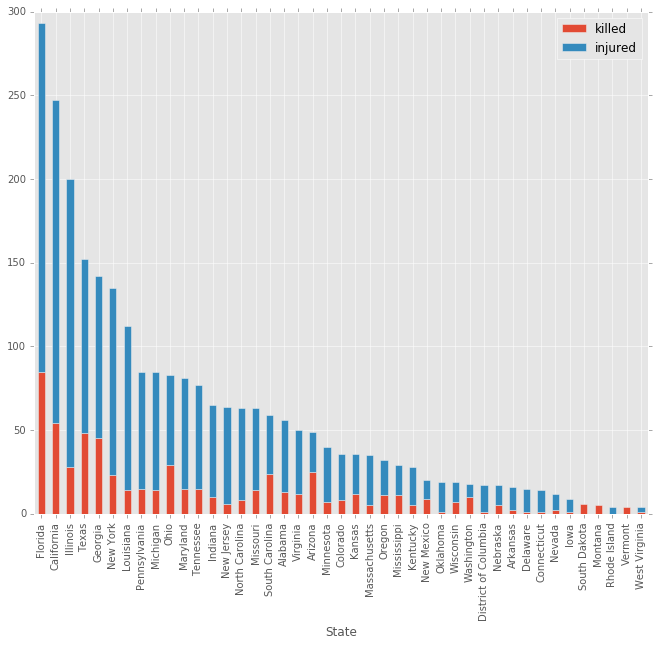

In [42]:
def count_affected(x): 
    return x['# Killed'].sum() + x['# Injured'].sum()

killed_counts = state_groups['# Killed'].sum()
injured_counts = state_groups['# Injured'].sum()
affected_counts = state_groups.apply(count_affected)
impact = pd.DataFrame(data={
        "killed": killed_counts,
        "injured": injured_counts,
        "affected": affected_counts})
impact = impact.sort_values(by=['affected'], ascending=False)
impact[['killed', 'injured']].plot(kind='bar', stacked=True)

In [61]:
demographic_filename = "data/zip_code_demographics.csv"
demographics = pd.read_csv(demographic_filename)
state_groups = demographics.groupby('State')
state_populations = state_groups['EstimatedPopulation'].sum()
state_populations.dropna(inplace=True)
state_populations = pd.DataFrame(data=state_populations)
state_populations.head()

,EstimatedPopulation
State,
AK,553665.0
AL,3671857.0
AR,2134523.0
AZ,4437076.0
CA,28218566.0


In [58]:
state_table = pd.read_csv('data/state_table.csv')
state_table.head()

,id,name,abbreviation,country,type,sort,status,occupied,notes,fips_state,assoc_press,standard_federal_region,census_region,census_region_name,census_division,census_division_name,circuit_court
0,1,Alabama,AL,USA,state,10,current,occupied,NaN,1.0,Ala.,IV,3.0,South,6.0,East South Central,11
1,2,Alaska,AK,USA,state,10,current,occupied,NaN,2.0,Alaska,X,4.0,West,9.0,Pacific,9
2,3,Arizona,AZ,USA,state,10,current,occupied,NaN,4.0,Ariz.,IX,4.0,West,8.0,Mountain,9
3,4,Arkansas,AR,USA,state,10,current,occupied,NaN,5.0,Ark.,VI,3.0,South,7.0,West South Central,8
4,5,California,CA,USA,state,10,current,occupied,NaN,6.0,Calif.,IX,4.0,West,9.0,Pacific,9


In [72]:
populated_states = pd.merge(state_populations, state_table[['abbreviation', 'name']], left_index="State", right_on='abbreviation')
populated_states.head()

,EstimatedPopulation,abbreviation,name
1,553665.0,AK,Alaska
0,3671857.0,AL,Alabama
3,2134523.0,AR,Arkansas
2,4437076.0,AZ,Arizona
4,28218566.0,CA,California


In [111]:
def per_hundred_k(row):
    return(row.affected / row.EstimatedPopulation) * 100000

per_capita_impact = pd.merge(populated_states, impact, left_on='name', right_index='State', how='left')
per_capita_impact.fillna(0, inplace=True)
per_capita_impact['per_hundred_k'] = per_capita_impact.apply(per_hundred_k, axis=1)
per_capita_impact = per_capita_impact.sort_values(by=['per_hundred_k'], ascending=False)
per_capita_impact.head()

,EstimatedPopulation,abbreviation,name,affected,injured,killed,per_hundred_k
17,3393943.0,LA,Louisiana,112.0,98.0,14.0,3.299996
7,712642.0,DE,Delaware,15.0,14.0,1.0,2.104844
8,14669385.0,FL,Florida,293.0,208.0,85.0,1.997357
12,10354499.0,IL,Illinois,200.0,172.0,28.0,1.931528
9,7540717.0,GA,Georgia,142.0,97.0,45.0,1.883110


In [114]:
per_capita_impact.per_hundred_k.describe()

count    51.000000
mean      0.900990
std       0.679575
min       0.000000
25%       0.441095
50%       0.861912
75%       1.271663
max       3.299996
Name: per_hundred_k, dtype: float64

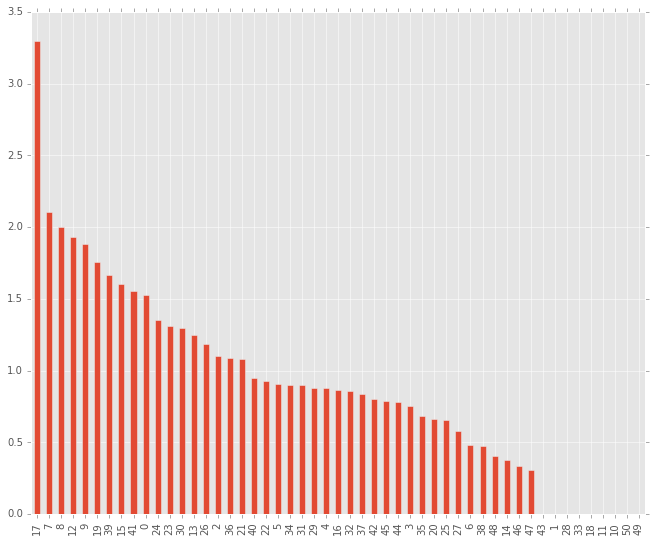

In [125]:
# df.plot(kind='bar', x=per_capita_impact.abbreviation, y=per_capita_impact.per_hundred_k)
x = per_capita_impact.per_hundred_k.plot(kind='bar')

,per_hundred_k
name,
Louisiana,3.299996
Delaware,2.104844
Florida,1.997357
Illinois,1.931528
Georgia,1.883110


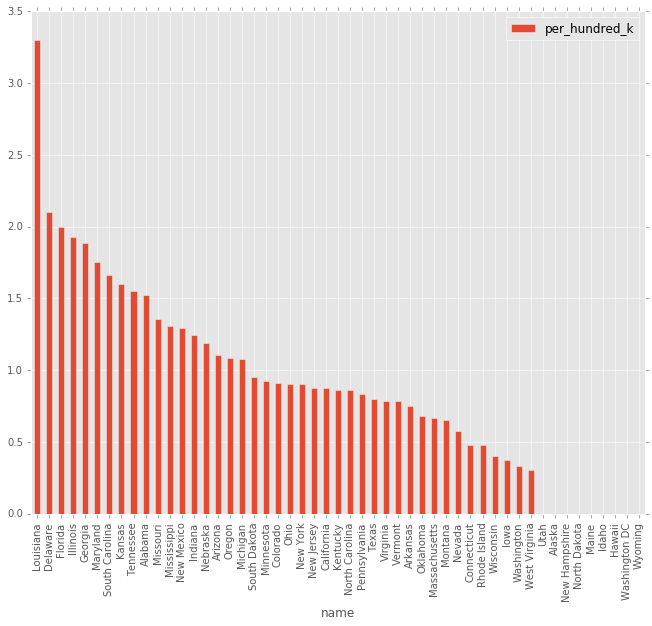

In [134]:
g = per_capita_impact.groupby('name')
df = pd.DataFrame(data=g.per_hundred_k.mean(), index=per_capita_impact.name)
df.plot(kind='bar')
df.head()

So, that was difficult.  I don't know how I got a merge issue, but when I merged states, something misaligned.  I'm OK with this for now.  The point is that Louisiana, Deleware, Maryland stick out much more aggressively when we consider per capita impact of mass shooting gun violence.